In [1]:
# for folders one level below the heirarchy
import sys
import os 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

from aodfunctions.dependencies import *
from aodfunctions.general import *
from aodfunctions.settings import *
from aodfunctions.testbed import *

cupyon=True

try:
    import cupy as cp
    import cupyx.scipy.fft as cpfft
    import cupyx.scipy.ndimage
    from cupyx.scipy.ndimage import gaussian_filter1d as cp_gaussian_filter1d
    from cupyx.scipy.ndimage import gaussian_filter as cp_gaussian_filter
    from cupyx.scipy.ndimage import affine_transform as cp_affine_transform
    from cupy.lib.stride_tricks import as_strided

except ImportError:
    cp = np
    cpfft = spfft
    cp_gaussian_filter1d = sp_gaussian_filter1d
    cp_gaussian_filter = sp_gaussian_filter
    cp_affine_transform = sp_affine_transform
    cupyon = False
    from numpy.lib.stride_tricks import as_strided
    print("cupy not installed. Using numpy.")


cupy not installed. Using numpy.
Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077
cupy not installed. Using numpy.


In [2]:
## Global Variables - REMEMBER TO UPDATE SETTINGS WHEN CHANGED
# Hardware-defined Constants. Note that all explicit variable values are in position (m), frequency (1/m), or time (s). Conversions are done explicitly to relevant time/distance scales.
aodaperture = 7.5e-3 # Aperture size of the AOD
soundvelocity = 650   # Sound velocity in the medium
cycletime = aodaperture / soundvelocity  # Time for one cycle of the waveform
focallength = 9.1 * 10**(-3) # mm
wavelength = 630 * 10**(-9)

print("Cycletime in nanoseconds: ", cycletime * 1e9)

# Simulation Constants
numpix_frame = 500
numpix_real = 4096
pixelsize_real = aodaperture / numpix_frame
aperturesize_real = numpix_real * pixelsize_real
aperturesize_fourier = wavelength * focallength / (pixelsize_real)
pixelsize_fourier = aperturesize_fourier / numpix_real
print("Aod pixel pitch in microns: ", pixelsize_real*1e6)
print("Fourier space spacing in microns: ", pixelsize_fourier*10**6)
print("Fourier space aperture in microns: ", aperturesize_fourier*10**6)

# Adjustable Variables
movementtime = 30*10**(-6) # Time for the movement of the AOD
timestep = cycletime / numpix_frame
print("Timestep in nanoseconds:", timestep * 10**9)
startlocation = -10*10**(-6) # Start location of the AOD in microns. 0 is set to the center of Fourier space.
endlocation = 10*10**(-6) # End location of the AOD in microns


optimizationbasisfunctions = 'Chebyshev'  # Basis for the polynomial fit
numcoefficients = 100

num_particles = 1000
atommass = 1.41922*10**(-25) # Mass of the atom
tweezerdepth = 10*10**6 # Depth of the tweezer in Hertz
hbar = 6.626*10**(-34)


globalvariables = [aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients]
aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables



Cycletime in nanoseconds:  11538.461538461537
Aod pixel pitch in microns:  14.999999999999998
Fourier space spacing in microns:  0.09331054687500001
Fourier space aperture in microns:  382.20000000000005
Timestep in nanoseconds: 23.076923076923077


In [3]:
### From the global variables, initialize the AWG waveform
numpix_waveform = int(movementtime / cycletime * numpix_frame) + 2* numpix_frame # Why is there a 2* cycletime here? To add on the initial and final stages of the AOD. We will only change the portion in the movement time and fix the ends.
AWGwaveform = cp.zeros(numpix_waveform)

print("Tweezer starting positions:", startlocation*10**6, "microns or", micronstoMHz(startlocation, globalvariables) /10**6, "MHz")
print("Tweezer ending positions:", endlocation*10**6, "microns or", micronstoMHz(endlocation, globalvariables) /10**6, "MHz")
print("One micron corresponds to", micronstoMHz(1e-6, globalvariables) /10**6, "MHz")

Tweezer starting positions: -10.0 microns or -1.133786848072562 MHz
Tweezer ending positions: 10.0 microns or 1.133786848072562 MHz
One micron corresponds to 0.1133786848072586 MHz


In [4]:
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_linearramp(globalvariables)
# optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time = initpath_minimizejerk(globalvariables)


optimized_position, optimized_velocity, optimized_acceleration, optimized_jerk, time  = initpath_sinsqramp(globalvariables)

fourierpixels, time = positionstofourier(optimized_position, time, globalvariables)
expanded_position, expanded_time = expand_position_array(time, fourierpixels, globalvariables)

AWGinitguess = initguess_waveform(AWGwaveform, optimized_position, time, globalvariables)
AWGinitguesscosine = cosinephaseresponse(AWGinitguess)
AWGinitguessexponential = exponentialphaseresponse(AWGinitguess)
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, True)
forces = retrieveforces(AWGinitguesscosine, globalvariables, 1, True)
initial_x_dx= initdistribution_MaxwellBoltzmann(num_particles, 40e-6, 1e-8, atommass, globalvariables)



# Mid-code visualizations
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())


# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [5]:
forces = retrieveforces_idealconditions(AWGinitguesscosine, optimized_position,globalvariables)

In [6]:
forces_notideal = retrieveforces(AWGinitguesscosine, globalvariables, 1, False)


In [7]:
potentials = retrievepotentials(AWGinitguesscosine, globalvariables, 1, False)

In [8]:
potentials_ideal = retrievepotentials_idealconditions(AWGinitguesscosine, optimized_position, globalvariables)

In [10]:
rescalingfac = np.max(np.gradient(potentials_ideal[0])) / np.max(gradient(potentials[0]))

In [11]:
rescalingfac2 = np.max((potentials_ideal[0])) / np.max((potentials[0]))

In [ ]:
rescalingfac2*potentials[0]

array([1.03532719e-26, 1.37866801e-25, 4.48993935e-25, ...,
       7.69488930e-25, 4.48993935e-25, 1.37866801e-25])

In [13]:
potentials[0]

array([9.68259065e-34, 1.28935839e-32, 4.19908269e-32, ...,
       7.19641713e-32, 4.19908269e-32, 1.28935839e-32])

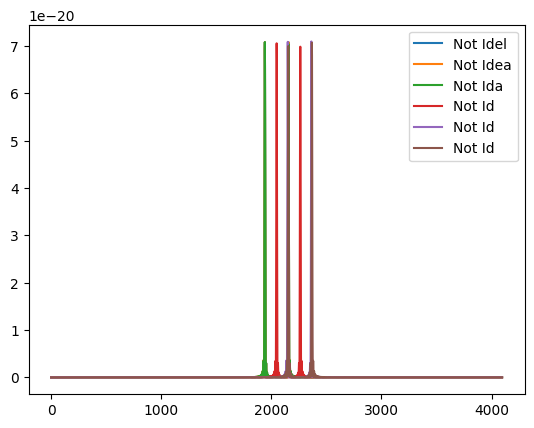

In [14]:
plt.plot(tonumpy(potentials[0]*rescalingfac2), label='Not Idel')
plt.plot(tonumpy(potentials[1800]*rescalingfac2), label='Not Idea')
plt.plot((potentials_ideal[0]), label='Not Ida')
plt.plot((potentials_ideal[900]), label='Not Id')
plt.plot((potentials_ideal[1600]), label='Not Id')
plt.plot((potentials_ideal[1700]), label='Not Id')

plt.legend()

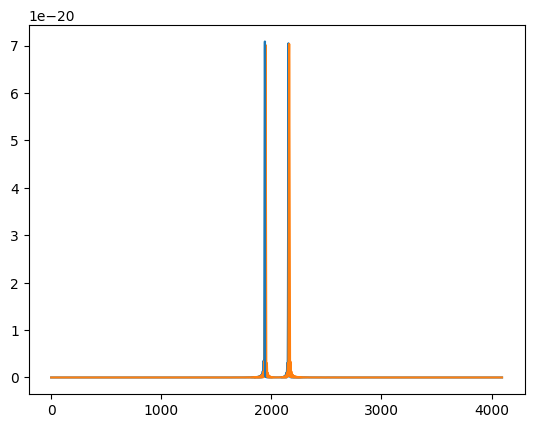

In [17]:
plt.plot(tonumpy(potentials_ideal[0]), label='Not Idel')
plt.plot(tonumpy(potentials_ideal[200]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[450]), label='Not Idel')

plt.plot(tonumpy(potentials_ideal[600]), label='Not Idel')

plt.vlines(x =find_max_peak_location((tonumpy(potentials_ideal[0]))), ymin = 0, ymax = np.max(tonumpy(potentials[0]*rescalingfac2)))


In [ ]:
positionstofourier(50e-6, 0, globalvariables)

(2583.845107273679, 0)

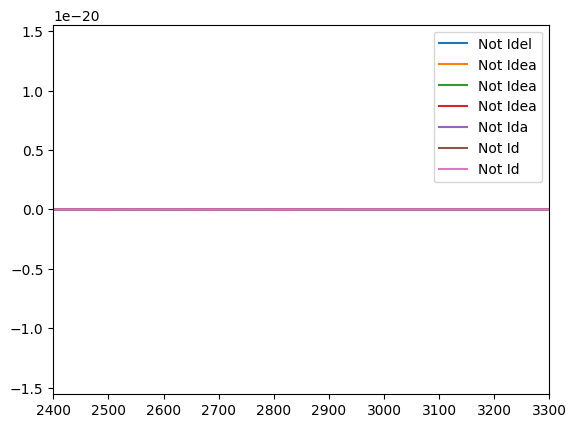

In [ ]:
plt.plot(gradient(potentials[500]).get()*rescalingfac, label='Not Idel')
plt.plot(gradient(potentials[1800]).get()*rescalingfac, label='Not Idea')
plt.plot(gradient(potentials[0]).get()*rescalingfac, label='Not Idea')
plt.plot(gradient(potentials[900]).get()*rescalingfac, label='Not Idea')

plt.plot(np.gradient(potentials_ideal[500]), label='Not Ida')
plt.plot(np.gradient(potentials_ideal[1800]), label='Not Id')
plt.plot(np.gradient(potentials_ideal[0]), label='Not Id')

plt.xlim(2400,3300)

plt.legend()

(2400.0, 3300.0)

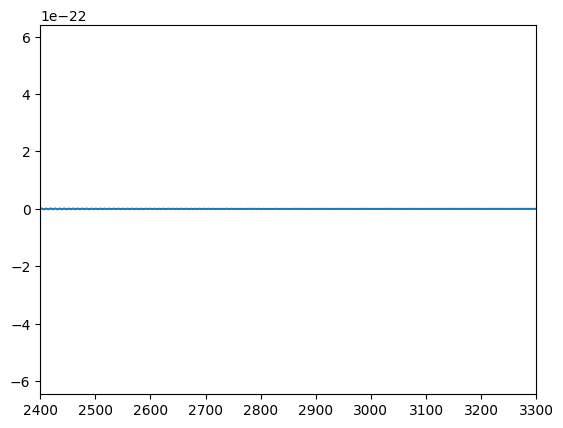

In [ ]:
plt.plot(gradient(potentials[900]).get()*rescalingfac, label='Not Idea')
plt.xlim(2400,3300)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


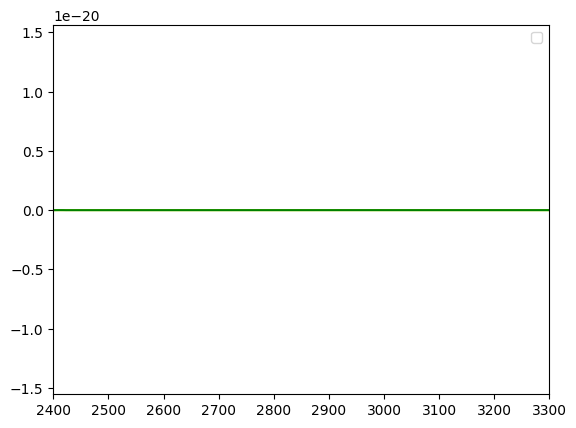

In [ ]:

plt.plot(forces[-1].get(), color='yellow')
plt.plot(forces_notideal[-1].get(), color='green')
plt.xlim(2400,3300)


plt.legend()

In [ ]:
# plot_arrays([(tonumpy(zoomin(potentials[0] /hbar/10**6, 2))), zoomin(forces[0] /hbar/10**6 /10**6,50000).get(),zoomin(forces[0] /atommass,50000).get()], ["Potential (MHz)", "Force (MHz / micron)", "Acceleration (m/s^2)"])

# plt.figure(figsize=(12, 6))
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[0:500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[3000:3500],globalvariables)).get())
# plt.plot(realtofourier(zeropadframe(AWGinitguesscosine[-500:],globalvariables)).get())
# plt.plot(potentials[-1].get())
# plt.plot(potentials[0].get())
# plt.xlim(2400,2900)

# plt.axvline(x=positionstofourier(startlocation, 0, globalvariables)[0], color='red', linestyle='--')
# plt.axvline(x=positionstofourier(endlocation, 0, globalvariables)[0], color='blue', linestyle='--')
# print(positionstofourier(startlocation, 0, globalvariables)[0])
# print(positionstofourier(endlocation, 0, globalvariables)[0])


# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# ax1.hist(initial_x_dx[0], color='blue')
# ax1.set_title('Position')
# ax1.set_xlabel('Fourier Pixels')
# ax1.set_ylabel('Count')

# ax2.hist(initial_x_dx[1], color='red')
# ax2.set_title('Velocity')
# ax2.set_xlabel('m/s')
# ax2.set_ylabel('Count')

# plt.tight_layout()
# plt.show()

In [ ]:
from aodfunctions.general import *

In [19]:
movetimes = np.arange(75,150,5)*10**(-6)
movetemperatures = np.array([1])*10**(-6)

# movetimes = np.array([200])*10**(-6)
# movetemperatures = np.array([1])*10**(-6)


ideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "Linear", 1, globalvariables)
notideallinear = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "Linear", 1, globalvariables)
idealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Ideal", "SinSq", 1, globalvariables)
notidealsinsq = analyze_fixeddistance_nonoptimized(movetimes,movetemperatures,"Exponential","Not Ideal", "SinSq", 1, globalvariables)


1.4030428114846503e-20
2155.202605337269
1.4028977969137068e-20
2155.2014233934137
1.403614515674774e-20
2155.20033931468
1.4026466059322652e-20
2155.1992828216794
1.402538078159741e-20
2155.1983201943494
1.4031556755933856e-20
2155.197431622247
1.4023464577452196e-20
2155.196612529481
1.402262206726342e-20
2155.1958584319323
1.4028046874075368e-20
2155.1951556668982
1.4021112371111788e-20
2155.1945020917483
1.4020439472686335e-20
2155.1938954295733
1.4025275532986362e-20
2155.19332569971
1.4019219461540883e-20
2155.1927921019246
1.4018669697804235e-20
2155.1922935094835
1.4023031983226664e-20
2155.191822387182
2.8774567193280477e-21
2155.202605337269
3.232984033221958e-21
2155.2014233934137
4.081593448845177e-21
2155.20033931468
4.863986617212565e-21
2155.1992828216794
5.560983732859418e-21
2155.1983201943494
6.194332573804053e-21
2155.197431622247
6.757238631995676e-21
2155.196612529481
7.263879491744216e-21
2155.1958584319323
7.731699421167056e-21
2155.1951556668982
8.13449913246168

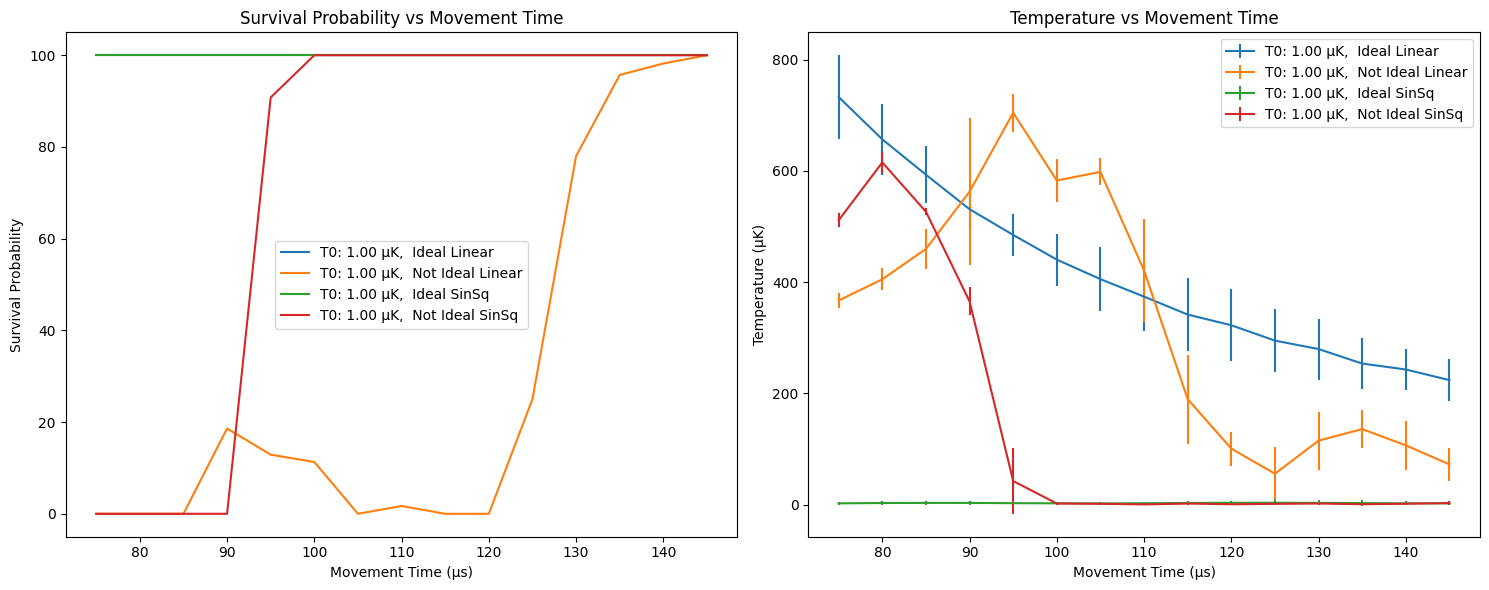

In [55]:
plots_fixeddistance_multipleanalysis(movetimes, movetemperatures, np.array([ideallinear, notideallinear, idealsinsq, notidealsinsq]), np.array(["Ideal Linear", "Not Ideal Linear", "Ideal SinSq", "Not Ideal SinSq"]))

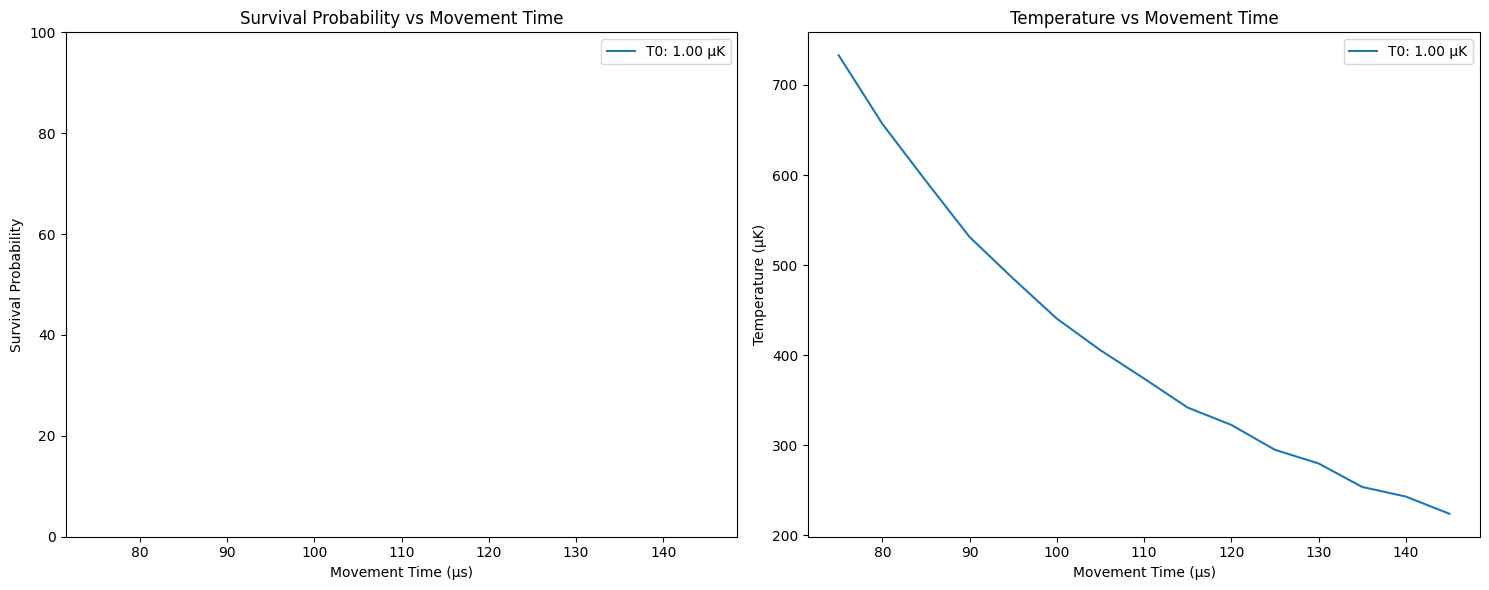

In [20]:
plots_fixeddistance(movetimes, movetemperatures, ideallinear)

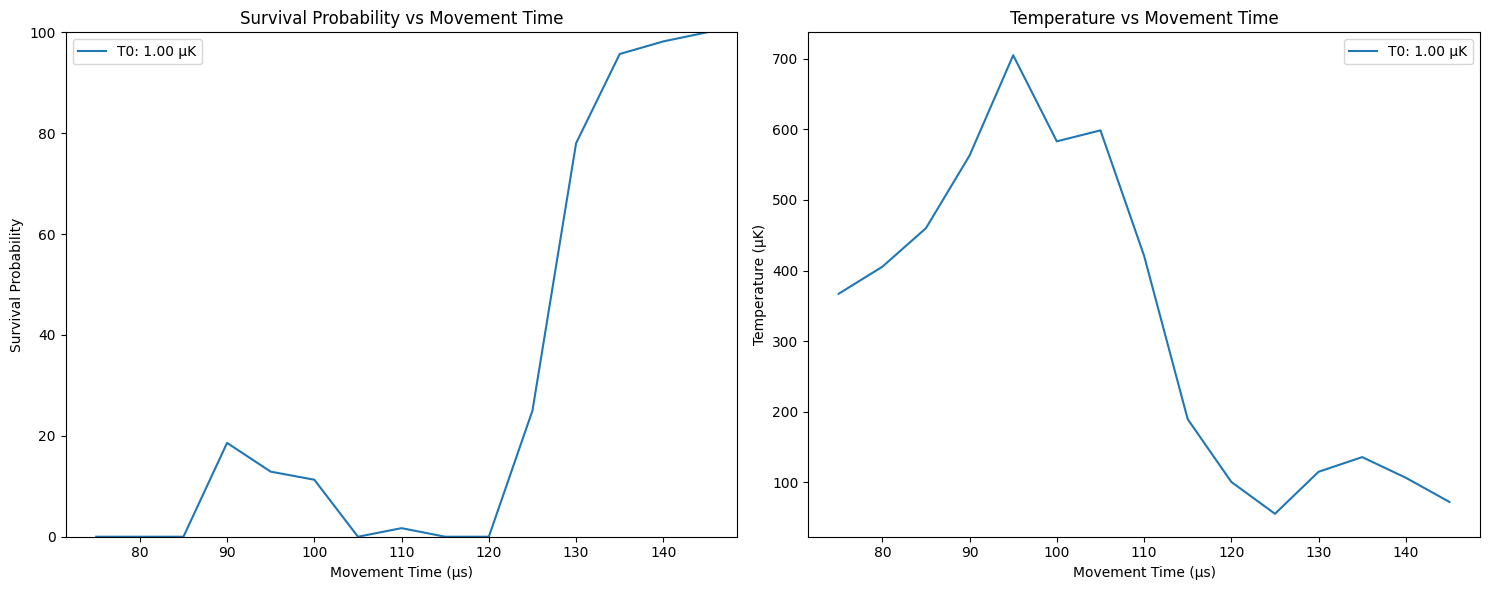

In [21]:
plots_fixeddistance(movetimes, movetemperatures, notideallinear)

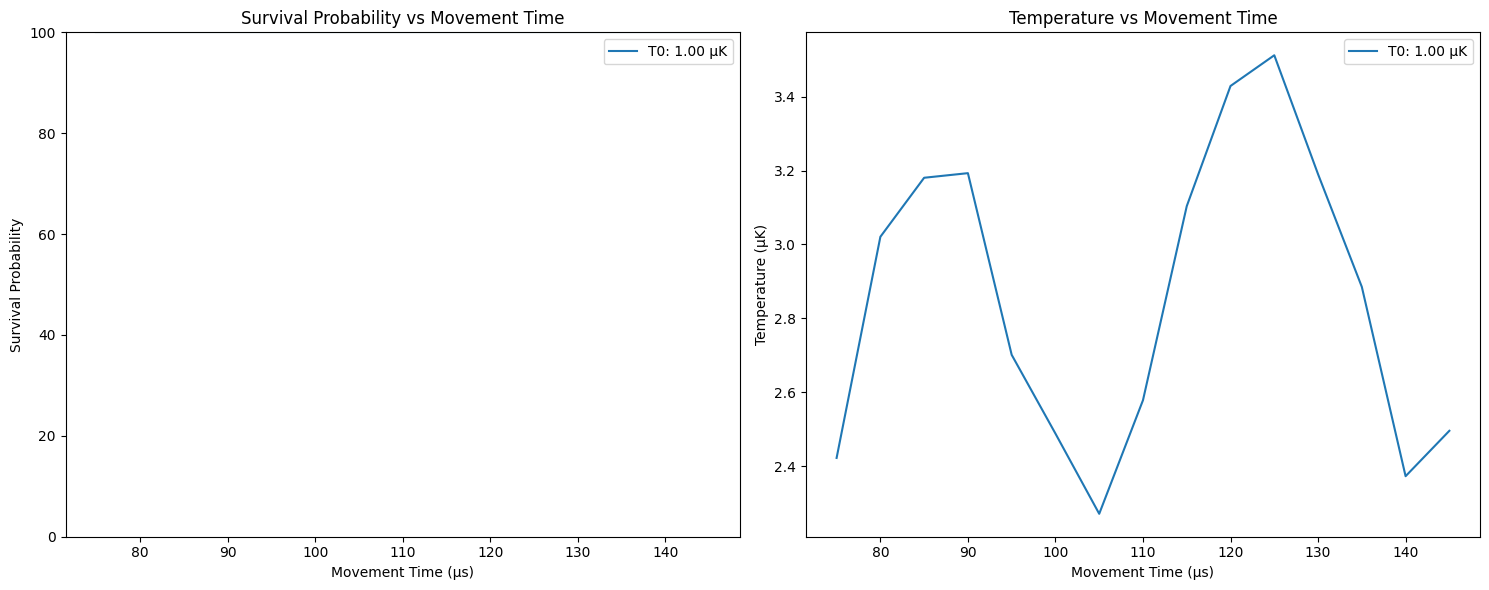

In [22]:
plots_fixeddistance(movetimes, movetemperatures, idealsinsq)

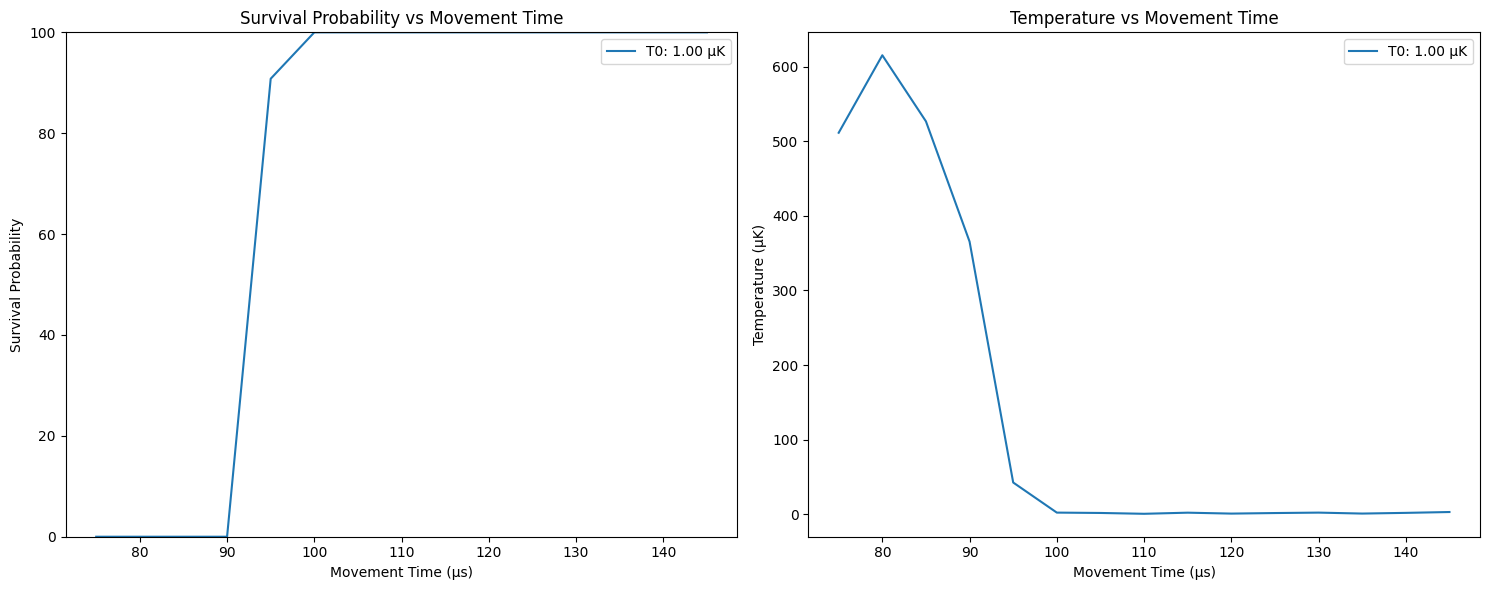

In [23]:
plots_fixeddistance(movetimes, movetemperatures, notidealsinsq)

In [42]:
from numpy.polynomial.legendre import legval
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution, minimize

def constructamplitudes(amplitudes, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    amplitudes = tonumpy(amplitudes)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, amplitudes)
    
    return tocupy(constructed_values)

def constructphases(phases, optimizationspace):
    ### Chose a Legendre basis for the optimization space
    phases = tonumpy(phases)
    optimizationspace = tonumpy(optimizationspace)
    
    constructed_values = legval(optimizationspace, phases)
    
    return tocupy(constructed_values)

def constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    constructedwaveform = cp.zeros(len(optimizationspace))
    for i in range(len(frequencies)):
        amplitudeprofile = constructamplitudes(amplitudes[i], optimizationspace)
        phaseprofile = constructphases(phases[i], optimizationspace)
        frequencyprofile = cp.linspace(frequencies[i], frequencies[i]*len(optimizationspace), len(optimizationspace))
        constructedwaveform += amplitudeprofile * np.cos(2*np.pi*frequencyprofile*optimizationspace + phaseprofile)
    
    return tocupy(constructedwaveform / cp.max(constructedwaveform))

def init_opt_waveformfitFourierVariant(AWGinitguess,freqres, ampres, phaseres, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(0,len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))[numpix_frame:-numpix_frame]
    
    startfrequency = positionstofourier(startlocation, 0, globalvariables)[0] - numpix_real // 2
    endfrequency = positionstofourier(endlocation, 0, globalvariables)[0] - numpix_real // 2
    
    
    frequencies = cp.linspace(startfrequency, endfrequency, freqres) # in units of pixels
    amplitudes = cp.random.rand(freqres, ampres) # arbitrary units
    phases = cp.zeros((freqres, phaseres)) # in units of pixels
        
    
    constructedwaveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables )
    
    
    def objective(params):
        num_frequencies = len(frequencies)
        num_amplitudes = ampres
        num_phases = phaseres
        
        amplitudes = tocupy(params[:num_frequencies * num_amplitudes].reshape((num_frequencies, num_amplitudes)))
        phases = tocupy(params[num_frequencies * num_amplitudes:].reshape((num_frequencies, num_phases)))
        
        reconstructed_waveform = constructFourierVariant(optimizationspace, frequencies, amplitudes, phases, globalvariables)
        error = cp.sum((reconstructed_waveform - optimizationsection)**2)
        print(error)
        return tonumpy(error)
    
    initial_guess = cp.concatenate([amplitudes.flatten(), phases.flatten()])


    # Second step: Local Gradient Descent
    result_gd = minimize(objective, tonumpy(initial_guess), method='L-BFGS-B')

    optimized_params = result_gd.x
    opt_amplitudes = optimized_params[:freqres * ampres].reshape((freqres, ampres))
    opt_phases = optimized_params[freqres * ampres:].reshape((freqres, phaseres))
    
    optimizedwaveform = constructFourierVariant(optimizationspace, frequencies, opt_amplitudes, opt_phases, globalvariables)
    
    AWGwaveform[numpix_frame:-numpix_frame] = optimizedwaveform
    parameters = [frequencies, opt_amplitudes, opt_phases]
    return AWGwaveform, parameters

def constructLegendre(optimizationspace, legendrecoefficients, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    constructedwaveform = legval(optimizationspace, legendrecoefficients)
    constructedwaveform = constructedwaveform / cp.max(constructedwaveform)
    return tocupy(constructedwaveform)

def init_opt_waveformfitLegendre(AWGinitguess,legendreres, globalvariables):
    aodaperture, soundvelocity, cycletime, focallength, wavelength, numpix_frame, numpix_real, pixelsize_real, aperturesize_real, aperturesize_fourier, pixelsize_fourier, movementtime, timestep, startlocation, endlocation, num_particles, atommass, tweezerdepth, hbar, optimizationbasisfunctions, numcoefficients = globalvariables
    
    AWGwaveform = cp.zeros(len(AWGinitguess))
    AWGwaveform[0:numpix_frame] = AWGinitguess[0:numpix_frame]
    AWGwaveform[-numpix_frame:] = AWGinitguess[-numpix_frame:]
    
    optimizationsection = AWGinitguess[numpix_frame:-numpix_frame]
    optimizationspace = cp.linspace(0,len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))[numpix_frame:-numpix_frame]
    
    startfrequency = positionstofourier(startlocation, 0, globalvariables)[0] - numpix_real // 2
    endfrequency = positionstofourier(endlocation, 0, globalvariables)[0] - numpix_real // 2
    
    
    legendrecoefficients = cp.random.rand(legendreres) # arbitrary units
        
    
    constructedwaveform = constructLegendre(optimizationspace, legendrecoefficients, globalvariables )
    
    
    def objective(params):  
        reconstructed_waveform = constructLegendre(optimizationspace, params, globalvariables)
        error = cp.sum((reconstructed_waveform - optimizationsection)**2)
        print(error)
        return error

    # Second step: Local Gradient Descent
    result_gd = minimize(objective, legendrecoefficients, method='L-BFGS-B')

    optimized_params = result_gd.x

    
    optimizedwaveform = constructFourierVariant(optimizationspace, optimized_params, globalvariables)
    
    AWGwaveform[numpix_frame:-numpix_frame] = optimizedwaveform
    return AWGwaveform, optimized_params


In [44]:
# fittedAWGguesscosine = init_opt_waveformfitFourierVariant(AWGinitguesscosine, 50, 30, 30, globalvariables)
fittedAWGguesslegendre = init_opt_waveformfitLegendre(AWGinitguesscosine, 1000, globalvariables)

731.722271841134
731.7222699895938
731.7222712610976
731.7222725054198
731.722272580314
731.7222717300585
731.7222711709361
731.722271567549
731.72227228628
731.7222723311277
731.7222716931876
731.722271305583
731.7222717021767
731.7222722785045
731.7222721943212
731.7222715967457
731.7222713805037
731.7222718537744
731.7222722945165
731.7222720462933
731.7222714971563
731.7222714767057
731.7222720026077
731.7222722734564
731.7222718917371
731.7222714470026
731.7222716018794
731.7222721022097
731.7222721952779
731.7222717682123
731.7222714759814
731.7222717299658
731.7222721179998
731.7222720748002
731.7222717113056
731.7222715782058
731.7222718254371
731.7222720484792
731.7222719483517
731.7222717311834
731.7222717167526
731.7222718660338
731.7222719272711
731.7222718526095
731.7222718050101
731.72227184284
731.7222718559574
731.722271807201
731.7222718057304
731.7222718872404
731.7222719191292
731.7222718237219
731.7222717356054
731.722271800155
731.7222719315623
731.7222719351912
73

KeyboardInterrupt: 

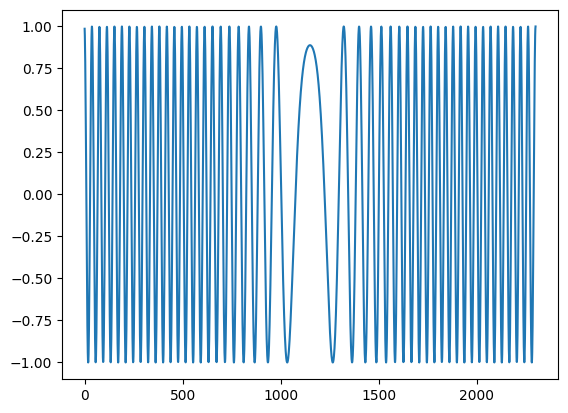

In [18]:
plt.plot(AWGinitguesscosine)

-107.16902145473568


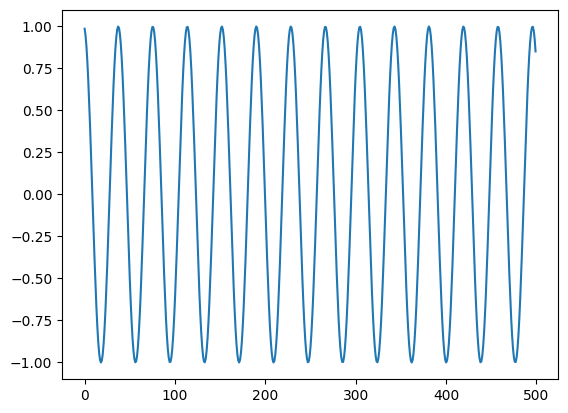

In [87]:
times = np.linspace(0,len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))
frequency1 = positionstofourier(-10e-6, 0, globalvariables)[0] - numpix_real // 2
print(frequency1)
frequencies = np.ones(len(AWGinitguesscosine)) * frequency1
test = np.cos(2*np.pi*np.cumsum(frequencies) *(times[1] - times[0]))

plt.plot(test[0:500])

In [88]:
np.cumsum(frequencies)

array([-1.07169021e+02, -2.14338043e+02, -3.21507064e+02, ...,
       -2.46274411e+05, -2.46381580e+05, -2.46488749e+05])

In [89]:
np.linspace(frequency1, frequency1*len(AWGinitguesscosine), len(AWGinitguesscosine))

array([-1.07169021e+02, -2.14338043e+02, -3.21507064e+02, ...,
       -2.46274411e+05, -2.46381580e+05, -2.46488749e+05])

In [76]:
len(AWGinitguesscosine)

2300

-107.16902145473568


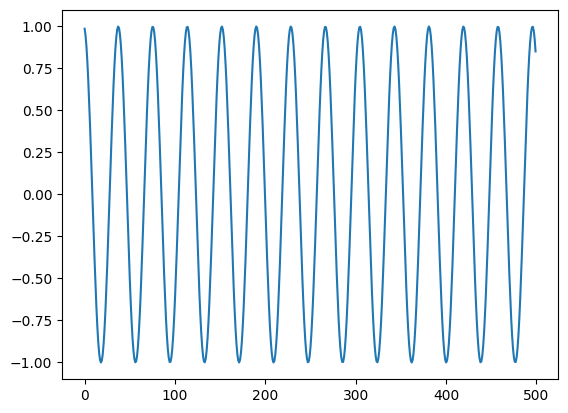

In [86]:
times = np.linspace(0,len(AWGinitguesscosine) / numpix_real,len(AWGinitguesscosine))
frequency1 = positionstofourier(-10e-6, 0, globalvariables)[0] - numpix_real // 2
print(frequency1)
frequencies = np.ones(len(AWGinitguesscosine)) * frequency1
test = np.cos(2*np.pi*np.cumsum(frequencies) *(times[1] - times[0]))

plt.plot(test[0:500])

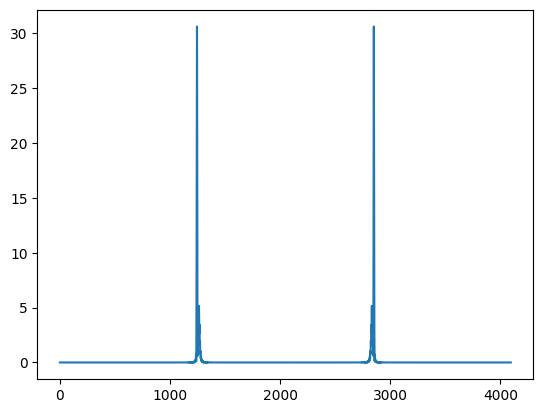

In [ ]:
plt.plot(potentials[-400].get())




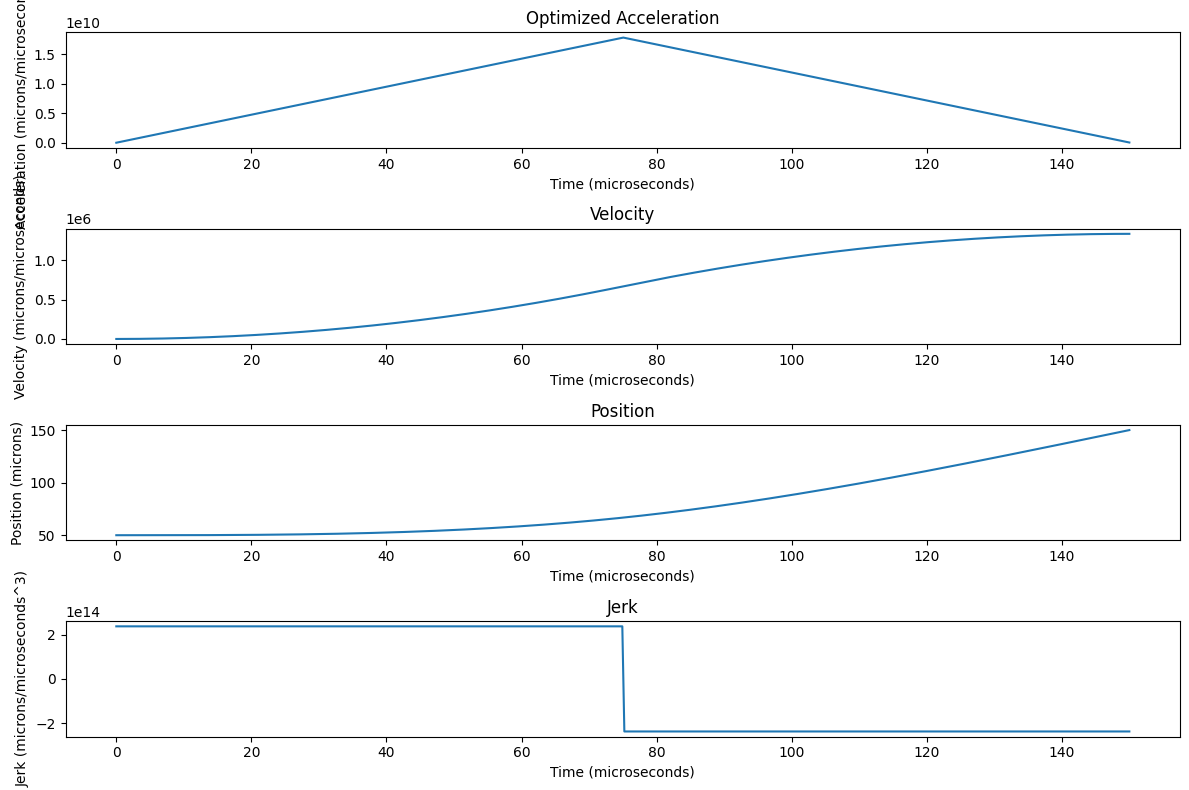

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(time * 10**6, optimized_acceleration * 10**6)
plt.title('Optimized Acceleration')
plt.xlabel('Time (microseconds)')
plt.ylabel('Acceleration (microns/microseconds^2)')

plt.subplot(4, 1, 2)
plt.plot(time* 10**6, optimized_velocity* 10**6)
plt.title('Velocity')
plt.xlabel('Time (microseconds)')
plt.ylabel('Velocity (microns/microseconds)')

plt.subplot(4, 1, 3)
plt.plot(time* 10**6, optimized_position* 10**6)
plt.title('Position')
plt.xlabel('Time (microseconds)')
plt.ylabel('Position (microns)')

plt.subplot(4, 1, 4)
plt.plot(time* 10**6, optimized_jerk* 10**6)
plt.title('Jerk')
plt.xlabel('Time (microseconds)')
plt.ylabel('Jerk (microns/microseconds^3)')

plt.tight_layout()
plt.show()